# Reading the dataset into a Panda DataFrame and coverting it to a list

In [1]:
#Authors: Arash N. Kia, Finbarr Murphy
#KBS, UL
#January 2020

import pandas as pd

dataset = pd.read_csv('/home/freeze/CAV/tesla_accident_desc.csv')

descriptions = list(dataset['Description'])


# Lemmatizing the description feature

In [2]:
import nltk
from nltk.corpus import wordnet

lmtzr = nltk.WordNetLemmatizer().lemmatize


def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


def normalize_text(text):
    word_pos = nltk.pos_tag(nltk.word_tokenize(text))
    lemm_words = [lmtzr(sw[0], get_wordnet_pos(sw[1])) for sw in word_pos]

    return [x.lower() for x in lemm_words]

corpus = [normalize_text(s) for s in descriptions]
descriptions = [' '.join(s) for s in corpus]

## Removing the stopwords using nltk

In [3]:
from nltk.corpus import stopwords

new_desc = []

for text in descriptions:
    new_desc.append(' '.join([word for word in text.split() if word not in stopwords.words("english")]))


# Removing the numbers from the description feature

In [4]:
import re
new_desc2 = [re.sub(r'\b[0-9]+\b\s*', '', s) for s in new_desc]
new_desc = new_desc2

## Using stemming package to stem the words in the descriptions

In [5]:
from stemming.porter2 import stem

documents = new_desc

documents = [[stem(word) for word in sentence.split(" ")] for sentence in documents]

descriptions = [' '.join(a) for a in documents]

# Using sklearn to eliminate the stopwords and "numbers in words" and learn a CountVectorizer to the dataset

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text 

# Tesla and number 18 should be eliminated. They won't give any useful information.
my_additional_stop_words = ['tesla',
        "zero", "one", "two", "three", "four", "five", "six", "seven", "eight",
        "nine", "ten", "eleven", "twelve", "thirteen", "fourteen", "fifteen",
        "sixteen", "seventeen", "eighteen", "nineteen", "twenty", "thirty", "forty", "fifty", "sixty", "seventy", "eighty", "ninety", 
                            "hundred", "thousand", "million", "billion", "trillion"]
stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words)

vect = CountVectorizer(stop_words = stop_words)
vect.fit(descriptions)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None,
                stop_words=frozenset({'a', 'about', 'above', 'across', 'after',
                                      'afterwards', 'again', 'against', 'all',
                                      'almost', 'alone', 'along', 'already',
                                      'also', 'although', 'always', 'am',
                                      'among', 'amongst', 'amoungst', 'amount',
                                      'an', 'and', 'another', 'any', 'anyhow',
                                      'anyone', 'anything', 'anyway',
                                      'anywhere', ...}),
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

# Making the document-term sparse matrix

In [7]:
docterm_matrix = vect.transform(descriptions)

In [29]:
# How will the exact textual form of the descriptions change after lemmatisation, stop-word removing, and stemming
a = CountVectorizer.inverse_transform(vect, docterm_matrix)
d = pd.DataFrame(a)
d.to_csv('/home/freeze/CAV/final_terms_description.csv', sep = ',')

# Make a csv out of vocabulary in Tesla description to check the vocabulary words before the next steps

In [8]:

dic = vect.vocabulary_
# Creating your dataframe from your dictionnary
df = pd.DataFrame([(k, v) for k, v in dic.items()], columns=['key', 'value'])
# Store the data into a csv file
df.to_csv('/home/freeze/CAV/tesla_accident_desc_words.csv', sep=',') # indicate the path where to store the csv file

# Concatenating other features of the accidents to text vector features

In [9]:
import numpy as np

other_features_dataset = pd.read_csv('/home/freeze/CAV/other_tesla_accident_features.csv')

other_features = other_features_dataset.values

docterm = docterm_matrix.todense()

final_features = np.hstack((docterm, other_features))

#print(final_features.shape)

# Clustering with K-Means and searching for the best K using Silhouette method

# Plotting the Silhouette vs K

In [10]:
data = final_features
print(data.shape)
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
X = data
s = []
for i in range(2, 106):
    kmeans = KMeans(n_clusters = i, random_state = 0).fit(X)
    s.append(silhouette_score(X, kmeans.labels_))
# kmeans.labels_



(105, 126)


/home/freeze/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: ConvergenceWarning: Number of distinct clusters (91) found smaller than n_clusters (92). Possibly due to duplicate points in X.
  if __name__ == '__main__':
/home/freeze/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: ConvergenceWarning: Number of distinct clusters (91) found smaller than n_clusters (93). Possibly due to duplicate points in X.
  if __name__ == '__main__':
/home/freeze/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: ConvergenceWarning: Number of distinct clusters (91) found smaller than n_clusters (94). Possibly due to duplicate points in X.
  if __name__ == '__main__':
/home/freeze/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: ConvergenceWarning: Number of distinct clusters (91) found smaller than n_clusters (95). Possibly due to duplicate points in X.
  if __name__ == '__main__':
/home/freeze/anaconda3/lib/python3.7/site-packages/ipykernel_launche

Text(0.5, 0, 'Number of segments')

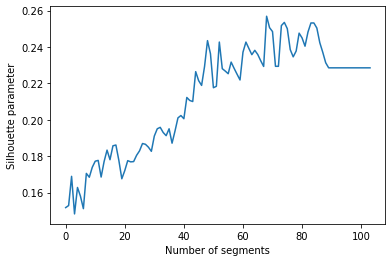

In [11]:
import matplotlib.pyplot as mlp
mlp.plot(s)
mlp.ylabel('Silhouette parameter')
mlp.xlabel('Number of segments')

# What is the best number of K? 

In [12]:
np.argmax(s) + 2

70

# Clustering with the best K and saving the results

In [13]:
kmeans = KMeans(n_clusters = np.argmax(s) + 2, random_state = 0).fit(X)

In [14]:
kmeans.labels_

array([17, 60, 42, 39,  7, 27, 61, 20, 51, 16, 47, 26, 12, 38, 24, 43, 31,
       64, 10, 11, 11, 13,  2, 10, 22, 24, 29, 48, 16,  0, 37, 16, 48, 34,
       64,  1, 14, 28, 54, 31, 16, 14, 38, 40, 41, 25,  6, 15, 36, 32, 19,
       35,  2,  3, 67, 63, 57,  5, 15, 62,  8,  4, 23, 58, 18,  1, 46, 69,
       36, 33, 59,  4,  3, 10, 49, 37, 37,  1, 44, 60, 30, 55, 65,  3, 68,
       16,  9,  1, 29, 56,  6, 38, 53, 50, 18, 66,  1, 45,  8, 45,  3, 52,
        5, 59, 21], dtype=int32)

In [15]:
np.savetxt("/home/freeze/CAV/tesla_segment_labels.csv", kmeans.labels_, delimiter = ',')

In [16]:
x = kmeans.labels_
y = np.sort(x)
print(y)

[ 0  1  1  1  1  1  2  2  3  3  3  3  4  4  5  5  6  6  7  8  8  9 10 10
 10 11 11 12 13 14 14 15 15 16 16 16 16 16 17 18 18 19 20 21 22 23 24 24
 25 26 27 28 29 29 30 31 31 32 33 34 35 36 36 37 37 37 38 38 38 39 40 41
 42 43 44 45 45 46 47 48 48 49 50 51 52 53 54 55 56 57 58 59 59 60 60 61
 62 63 64 64 65 66 67 68 69]


In [17]:
xx = np.unique(y)

In [18]:
yy = np.bincount(y)   

In [19]:
yy

array([1, 5, 2, 4, 2, 2, 2, 1, 2, 1, 3, 2, 1, 1, 2, 2, 5, 1, 2, 1, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 3, 3, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1,
       1, 1, 1, 1])

In [20]:
xx

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69], dtype=int32)

Text(50, 2.25, 'Filter Line')

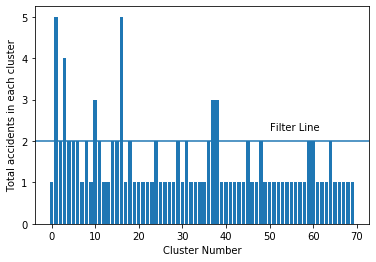

In [21]:
mlp.bar(xx, height = yy)
mlp.xlabel('Cluster Number')
mlp.ylabel('Total accidents in each cluster')
mlp.axhline(y = 2)
mlp.text(50, 2.25, 'Filter Line')